In [1]:
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter
from scipy.io import wavfile
from matplotlib import pyplot as plt

# Image: Smoothed noise
def generate_smoothed_noise(size=256):
    np.random.seed(15)
    noise = np.random.rand(size, size)
    smooth = gaussian_filter(noise, sigma=10)
    cv2.imwrite('smoothed_noise.png', (smooth * 255).astype(np.uint8))
    
# Audio: AM (Amplitude Modulation)
def generate_am_signal(fs=44100, duration=5):
    t = np.linspace(0, duration, int(fs * duration))
    carrier = np.sin(2 * np.pi * 1000 * t)
    modulator = (1 + np.sin(2 * np.pi * 5 * t)) / 2
    y = carrier * modulator
    wavfile.write('am_signal.wav', fs, (y * 32767).astype(np.int16))
    
generate_smoothed_noise()
generate_am_signal()

/home/lpo/.sage/local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


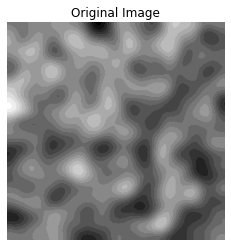

In [2]:
# Load image in grayscale
image = cv2.imread('smoothed_noise.png', cv2.IMREAD_GRAYSCALE)

plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

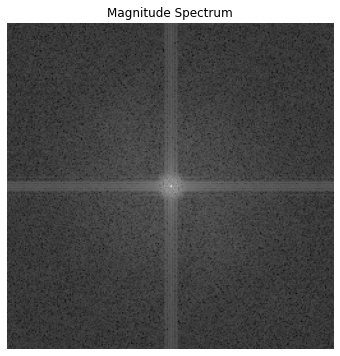

In [3]:
# Compute 2D FFT
f = np.fft.fft2(image)
fshift = np.fft.fftshift(f)  # Shift zero freq. to center

# Compute magnitude spectrum
magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)

plt.figure(figsize=(6,6))
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum')
plt.axis('off')
plt.show()

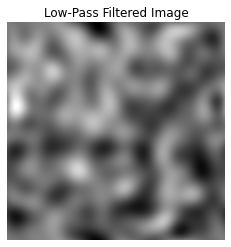

In [4]:
rows, cols = image.shape
crow, ccol = rows // 2 , cols // 2

# Create a low-pass filter mask (circle in the center)
mask_lp = np.zeros((rows, cols), np.uint8)
r = 10  # Radius
cv2.circle(mask_lp, (ccol, crow), r, 1, thickness=-1)

# Create high-pass mask as complement
mask_hp = 1 - mask_lp

# Apply the masks
fshift_lp = fshift * mask_lp
fshift_hp = fshift * mask_hp

# Inverse shift and IFFT for low-pass
f_ishift_lp = np.fft.ifftshift(fshift_lp)
img_back_lp = np.fft.ifft2(f_ishift_lp)
img_back_lp = np.abs(img_back_lp)

# Display the result
plt.imshow(img_back_lp, cmap='gray')
plt.title('Low-Pass Filtered Image')
plt.axis('off')
plt.show()

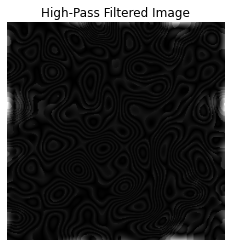

In [5]:
# Inverse shift and IFFT for low-pass
f_ishift_hp = np.fft.ifftshift(fshift_hp)
img_back_hp = np.fft.ifft2(f_ishift_hp)
img_back_hp = np.abs(img_back_hp)

# Display the result
plt.imshow(img_back_hp, cmap='gray')
plt.title('High-Pass Filtered Image')
plt.axis('off')
plt.show()

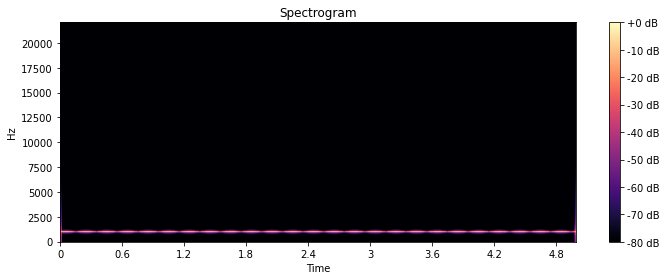

In [6]:
import librosa
import librosa.display

# Load audio file
y, sr = librosa.load('am_signal.wav', sr=None)

# Compute STFT
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# Display spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.tight_layout()
plt.show()

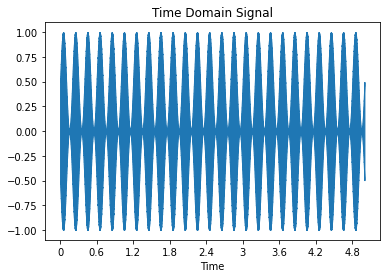

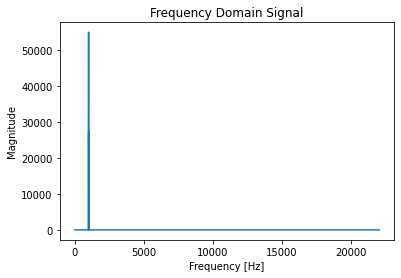

In [7]:
# Plot waveform (time domain)
plt.figure()
librosa.display.waveshow(y, sr=sr)
plt.title('Time Domain Signal')

# Plot magnitude spectrum (frequency domain)
Y = np.fft.fft(y)
freqs = np.fft.fftfreq(len(Y), 1/sr)
plt.figure()
# plt.plot(freqs, np.abs(Y))
plt.plot(freqs[:len(freqs)//2], np.abs(Y[:len(Y)//2]))
plt.title('Frequency Domain Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.show()